# BERT EN Model

### This notebook contains the implementation of the ELECTRA model pre-trained on the english language set coming from `Datasets/BERT/train_en.csv`

### The following steps are taken to establish the model
- **Data exploration and visualization**
- **Tokenizer selection**
- **Preprocessor selection**
- **Backbone selection**
- **Classifier selction**
- **Any additional hyperparameter searching and tuning**
- **Model saving**

In [17]:
import matplotlib.pyplot as plt
import pandas
import numpy
import torch
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras_nlp
import keras

#### Data Exploration and Visualization

In [2]:
BERT_en_dataset = pandas.read_csv("Datasets/BERT/train_en.csv")
BERT_en_dataset.head()

,Unnamed: 0,id,premise,hypothesis,lang_abv,language,label,label_name
0,0,a937bd90a8,"3) Dare you rise to the occasion, like Raskol...",Would you rise up and defeaat all evil lords i...,en,English,1,neutral
1,1,0abb9434d5,"He married Dona Filipa Moniz (Perestrelo), the...",He landed on the island but soon left for gree...,en,English,2,contradiction
2,2,bc52edfd5b,The contrast between the landscape of the cent...,There was a beautiful artist who painted the l...,en,English,1,neutral
3,3,62344708db,i don't know i i do i can think of all the uh ...,I know this because I own a bible.,en,English,1,neutral
4,4,03f3c9a92e,'So I assume he hacked into the autopilot and ...,I'm assuming he hacked the autopilot to bring ...,en,English,1,neutral


In [3]:
BERT_en_dataset.isna().sum()

Unnamed: 0    0
id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
label_name    0
dtype: int64

In [4]:
(BERT_en_dataset.lang_abv != "en").sum()

np.int64(0)

In [5]:
BERT_en_dataset.label[~BERT_en_dataset.label.isin([0, 1, 2])].any()

np.False_

In [6]:
BERT_en_dataset.id.count()

np.int64(3435)

In [7]:
BERT_en_dataset.hypothesis.describe()

count               3435
unique              3435
top       Did you do it?
freq                   1
Name: hypothesis, dtype: object

In [8]:
for i in range(10):
    print(BERT_en_dataset.hypothesis[i])

Would you rise up and defeaat all evil lords in the town?
He landed on the island but soon left for greener pastures, before later dying alone and childless.
There was a beautiful artist who painted the landscape of the central highlands.
I know this because I own a bible.
I'm assuming he hacked the autopilot to bring the plane down.
They would make pilgrimages to Jerusalem.
A traveler said the settlement was prospering. 
TIG funds are used to support the Technology Evolution project, a legal aid society in Cincinnati. 
I could not agree with you.
You were thought to be dead!


In [9]:
BERT_en_dataset.premise.describe()

count                                                  3435
unique                                                 2380
top       Additional information is provided to help man...
freq                                                      3
Name: premise, dtype: object

In [10]:
for i in range(10):
    print(BERT_en_dataset.premise[i])

3)  Dare you rise to the occasion, like Raskolnikov, and reject the petty rules that govern lesser men?
He married Dona Filipa Moniz (Perestrelo), the daughter of Porto Santo's first governor, and lived on the island for a period, fathering a son there.
The contrast between the landscape of the central highlands and the south coast could not be more marked.
i don't know i i do i can think of all the uh the biblical things about it too where what did they say to uh i can't think of the scripture Render unto Caesar's what is Caesar's so
'So I assume he hacked into the autopilot and reprogrammed it to-'
They returned to live in the Galilee village of Nazareth, making pilgrimages to Jerusalem.
An Indian traveler described the prosperous Bujang Valley settlement as  the seat of all felicities.  
TIG funds support the Technology Evaluation Project, an initiative of the Legal Aid Society of Cincinnati.
well i think i got to agree with you there
Say, man, don't you know you've been given up fo

In [11]:
BERT_en_dataset.label.describe()

count    3435.000000
mean        0.984862
std         0.823577
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         2.000000
Name: label, dtype: float64

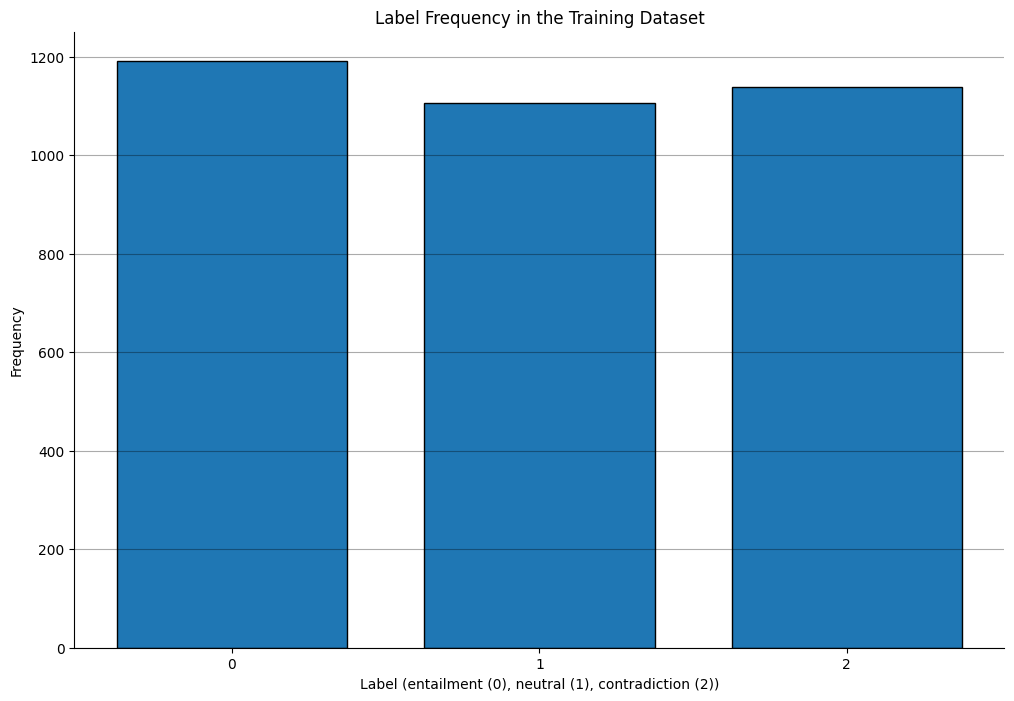

In [12]:
labels = BERT_en_dataset.label.to_numpy()

plt.figure(figsize=(12, 8))

plt.hist(labels, bins=range(4), align="left", rwidth=0.75, edgecolor="black")

plt.xticks(numpy.arange(3))

for pos in ["top", "right"]:
    plt.gca().spines[pos].set_visible(False)

plt.grid(axis="y", alpha=0.33, color="black")

plt.xlabel("Label (entailment (0), neutral (1), contradiction (2))")

plt.ylabel("Frequency")

plt.title("Label Frequency in the Training Dataset")

plt.show()

In [13]:
def get_length_of_text(_text):
    return len(_text)


length_of_hypothesis_texts = BERT_en_dataset.hypothesis.apply(get_length_of_text)

length_of_premise_texts = BERT_en_dataset.premise.apply(get_length_of_text)

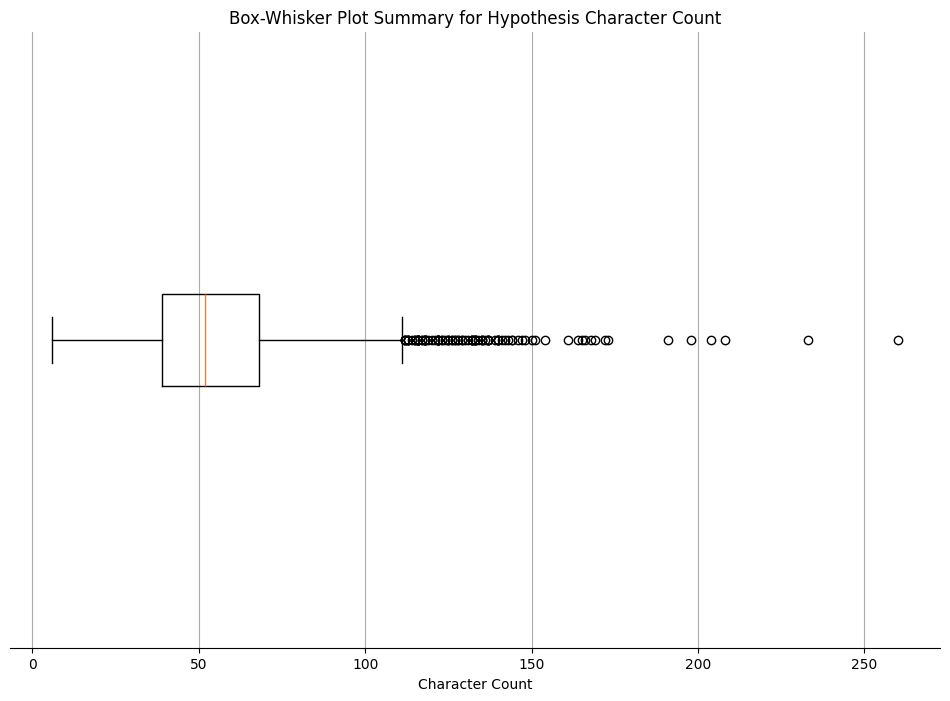

In [14]:
plt.figure(figsize=(12, 8))

plt.boxplot(length_of_hypothesis_texts, vert=False)

for pos in ["top", "right", "left"]:
    plt.gca().spines[pos].set_visible(False)

plt.gca().get_yaxis().set_visible(False)

plt.grid(axis="x", alpha=0.33, color="black")

plt.xlabel("Character Count")

plt.title("Box-Whisker Plot Summary for Hypothesis Character Count")

plt.show()

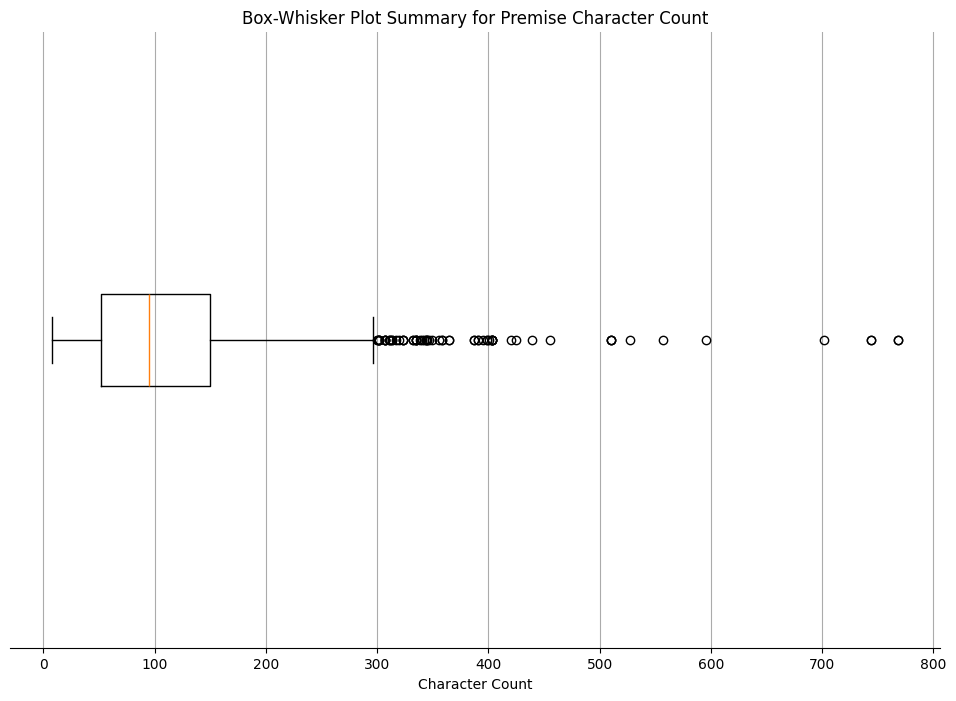

In [15]:
plt.figure(figsize=(12, 8))

plt.boxplot(length_of_premise_texts, vert=False)

for pos in ["top", "right", "left"]:
    plt.gca().spines[pos].set_visible(False)

plt.gca().get_yaxis().set_visible(False)

plt.grid(axis="x", alpha=0.33, color="black")

plt.xlabel("Character Count")

plt.title("Box-Whisker Plot Summary for Premise Character Count")

plt.show()

## Turning data frame to tensor data

[['3)  Dare you rise to the occasion, like Raskolnikov, and reject the petty rules that govern lesser men?'
  'Would you rise up and defeaat all evil lords in the town?']
 ["He married Dona Filipa Moniz (Perestrelo), the daughter of Porto Santo's first governor, and lived on the island for a period, fathering a son there."
  'He landed on the island but soon left for greener pastures, before later dying alone and childless.']
 ['The contrast between the landscape of the central highlands and the south coast could not be more marked.'
  'There was a beautiful artist who painted the landscape of the central highlands.']
 ...
 ['The village is Sainte-Marie, named by the explorer when he landed on 4 November 1493, attracted by the waterfalls and river he could see flowing down the green inland mountains.'
  'He was attracted by the waterfalls and river.']
 ['Homes or businesses not located on one of these roads must place a mail receptacle along the route traveled.'
  'The homes and busine

TypeError: 'int' object is not callable